---
# Zillow Clustering Project 
---

<img src="https://1000logos.net/wp-content/uploads/2017/12/Zillow_logo_PNG2.png" alt="Zillow" title="Zillow Logo" width="400" height="200" />

---
## Executive Summary
---

**Goals:**
- Find predictors of Zestimate log error
- Construct a ML regression model that accurately predicts Zestimate log error
- Use clustering as part of exploration process

**Results:**
- Add results here

**Next Steps:**
- Add next steps here

---

### Data Dictionary

---
## Plan
---

- [x] Create README.md with data dictionary, project and business goals, come up with initial hypotheses.
- [x] Acquire data from the Codeup Database and create a function to automate this process. Save the function in an acquire.py file to import into the Final Report Notebook.
- [x] Clean and prepare data for the first iteration through the pipeline, MVP preparation. Create a function to automate the process, store the function in a prepare.py module, and prepare data in Final Report Notebook by importing and using the funtion.
- [x] Clearly define at least two hypotheses, set an alpha, run the statistical tests needed, reject or fail to reject the Null Hypothesis, and document findings and takeaways.
- [x] Incorporate clustering into exploration process.
- [x] Establish a baseline accuracy and document well.
- [x] Train several different regression models.
- [x] Evaluate models on train and validate datasets.
- [x] Choose the model with that performs the best and evaluate that single model on the test dataset.
- [x] Document conclusions, takeaways, and next steps in the Final Report Notebook.

---
## Acquire
---

In [1]:
# standard imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy import stats

# sklearn imports
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# supress scientific notation
np.set_printoptions(suppress=True)

# Custom module imports
import wrangle as w
import explore as e
import evaluate as ev 

In [2]:
# use function from wrangle module to acquire needed data, see wrangle.py for code
df = w.get_zillow_data()

In [3]:
df.head()

,typeconstructiontypeid,storytypeid,propertylandusetypeid,heatingorsystemtypeid,buildingclasstypeid,architecturalstyletypeid,airconditioningtypeid,parcelid,transactiondate,id,...,censustractandblock,id,logerror,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,NaN,NaN,261.0,NaN,NaN,NaN,NaN,14297519,2017-01-01,1727539,...,6.059063e+13,0,0.025595,None,None,None,None,Single Family Residential,None,None
1,NaN,NaN,261.0,NaN,NaN,NaN,NaN,17052889,2017-01-01,1387261,...,6.111001e+13,1,0.055619,None,None,None,None,Single Family Residential,None,None
2,NaN,NaN,261.0,NaN,NaN,NaN,NaN,14186244,2017-01-01,11677,...,6.059022e+13,2,0.005383,None,None,None,None,Single Family Residential,None,None
3,NaN,NaN,261.0,2.0,NaN,NaN,NaN,12177905,2017-01-01,2288172,...,6.037300e+13,3,-0.103410,None,None,None,Central,Single Family Residential,None,None
4,NaN,NaN,266.0,2.0,NaN,NaN,1.0,10887214,2017-01-01,1970746,...,6.037124e+13,4,0.006940,Central,None,None,Central,Condominium,None,None


In [4]:
df.shape

(77381, 69)

In [5]:
# df.describe()

In [6]:
# df.info()

In [7]:
# fig, axs = plt.subplots(10, 5, sharey=False, figsize=(25, 50))
# axe = axs.ravel()
# for i, c in enumerate(df.select_dtypes('number').columns):
#     df[c].plot.hist(ax=axe[i],title=c, ec='black')
#     plt.tight_layout()

### Takeaways:
- Have some outliers/erroneous data in most columns
- Lots of nulls
- I am starting with a df with a shape of (77381, 69)
- Description of initial data pull:
    - Only properties from 2017
    - Only pulled records for most recent transaction date
    - Joined all possible tables to bring in all data available
    - Only pulled records where both latitude and longitude columns had values

---
## Prepare
---

### Clean

In [8]:
# use function to clean data, see wrangle.py for code
df = w.clean_zillow(df)
df.head()

,sale_date,bath_cnt,bed_cnt,sqft,latitude,longitude,lot_sqft,land_use_code,zoning_desc,total_rooms,year_built,assessed_value,census_tract_block,log_error,heating_system,land_use,county,sale_month,sale_week
0,2017-01-01,3.5,4,3100,33.634931,-117.869207,4506,122,LAR1,8,1998,1023282.0,060590630072012,0.025595,Central,Single Family Residential,Orange,1,52
2,2017-01-01,2.0,3,1243,33.886168,-117.823170,8432,122,LAR1,6,1962,564778.0,060590218022012,0.005383,Central,Single Family Residential,Orange,1,52
7,2017-01-01,1.0,2,738,34.149214,-118.239357,4214,0100,GLR4YY,3,1922,218552.0,060373020041001,0.101723,Central,Single Family Residential,Los Angeles,1,52
10,2017-01-02,3.0,4,2540,34.434971,-118.464390,10384,0101,SCUR2,8,1999,430108.0,060379200341014,0.005963,Central,Single Family Residential,Los Angeles,1,1
15,2017-01-02,2.5,3,1371,34.238229,-119.170633,3445,1111,LAR1,6,2004,198054.0,061110050041163,0.008669,Central,Single Family Residential,Ventura,1,1


In [9]:
df.shape

(41062, 19)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41062 entries, 0 to 77380
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   sale_date           41062 non-null  datetime64[ns]
 1   bath_cnt            41062 non-null  float64       
 2   bed_cnt             41062 non-null  int64         
 3   sqft                41062 non-null  int64         
 4   latitude            41062 non-null  float64       
 5   longitude           41062 non-null  float64       
 6   lot_sqft            41062 non-null  int64         
 7   land_use_code       41062 non-null  object        
 8   zoning_desc         41062 non-null  object        
 9   total_rooms         41062 non-null  int64         
 10  year_built          41062 non-null  int64         
 11  assessed_value      41062 non-null  float64       
 12  census_tract_block  41062 non-null  object        
 13  log_error           41062 non-null  float64   

#### Cleaning Performed:
- Dropped id columns
- Filtered to single-unit properties by using only `Single Family Residential`, `Mobile Home`, and `Manufactured, Modular, Prefabricated Homes` labels from `land_use` column
- Removed all `columns` with more than `50%` of data missing
- Removed all `rows` with more than `25%` missing
- Imputed missing `sqft` and `lot_sqft` values using median
- Imputed `zoning_desc`, `heating_system` values using mode
- Renamed `county` ids using names
- Reformatted `latitude` and `longitude` columns to stardard format
- Dropped all remaining nulls
- Dropped other redundant columns and columns that didn't columns where values were all the same
- Fixed data types to be appropriate for info contained in each column
- Removed outliers using Tukey's Rule (1.5 * IQR)
- Renamed columns as necessary for readability
- Added `sale_month` and `sale_week` columns to be used in exploration

#### Takeaways:
- Current shape of data: (41062, 19)

---
### Split for Exploration

In [11]:
# split df for exploration
train_exp, val_exp, test_exp = w.split(df)
print(train_exp.shape, val_exp.shape, test_exp.shape)
print(train_exp.shape[0]/df.shape[0], val_exp.shape[0]/df.shape[0], test_exp.shape[0]/df.shape[0])
train_exp.head()

(32889, 19) (4066, 19) (4107, 19)
0.8009595246213044 0.09902099264526813 0.1000194827334275


,sale_date,bath_cnt,bed_cnt,sqft,latitude,longitude,lot_sqft,land_use_code,zoning_desc,total_rooms,year_built,assessed_value,census_tract_block,log_error,heating_system,land_use,county,sale_month,sale_week
14152,2017-03-02,3.0,4,2212,33.614040,-117.907805,4900,122,LAR1,7,1946,137274.0,060590634005023,0.034114,Central,Single Family Residential,Orange,3,9
46765,2017-06-15,3.0,4,2002,34.192037,-118.315270,7309,0100,BUR1*,8,1941,409818.0,060373106021010,-0.047764,Floor/Wall,Single Family Residential,Los Angeles,6,24
36185,2017-05-15,2.0,5,1982,33.677214,-117.952371,6000,122,LAR1,8,1964,334694.0,060590992162014,-0.019793,Central,Single Family Residential,Orange,5,20
52616,2017-06-30,3.0,5,2406,34.651216,-118.251613,10020,0101,LCRA10000*,9,1997,322000.0,060379012053008,-0.015435,Central,Single Family Residential,Los Angeles,6,26
11667,2017-02-23,2.0,3,1041,33.935264,-117.924937,5860,122,LAR1,6,1957,371706.0,060590014021007,-0.041416,Central,Single Family Residential,Orange,2,8


---
## Explore 
---

### Univariate

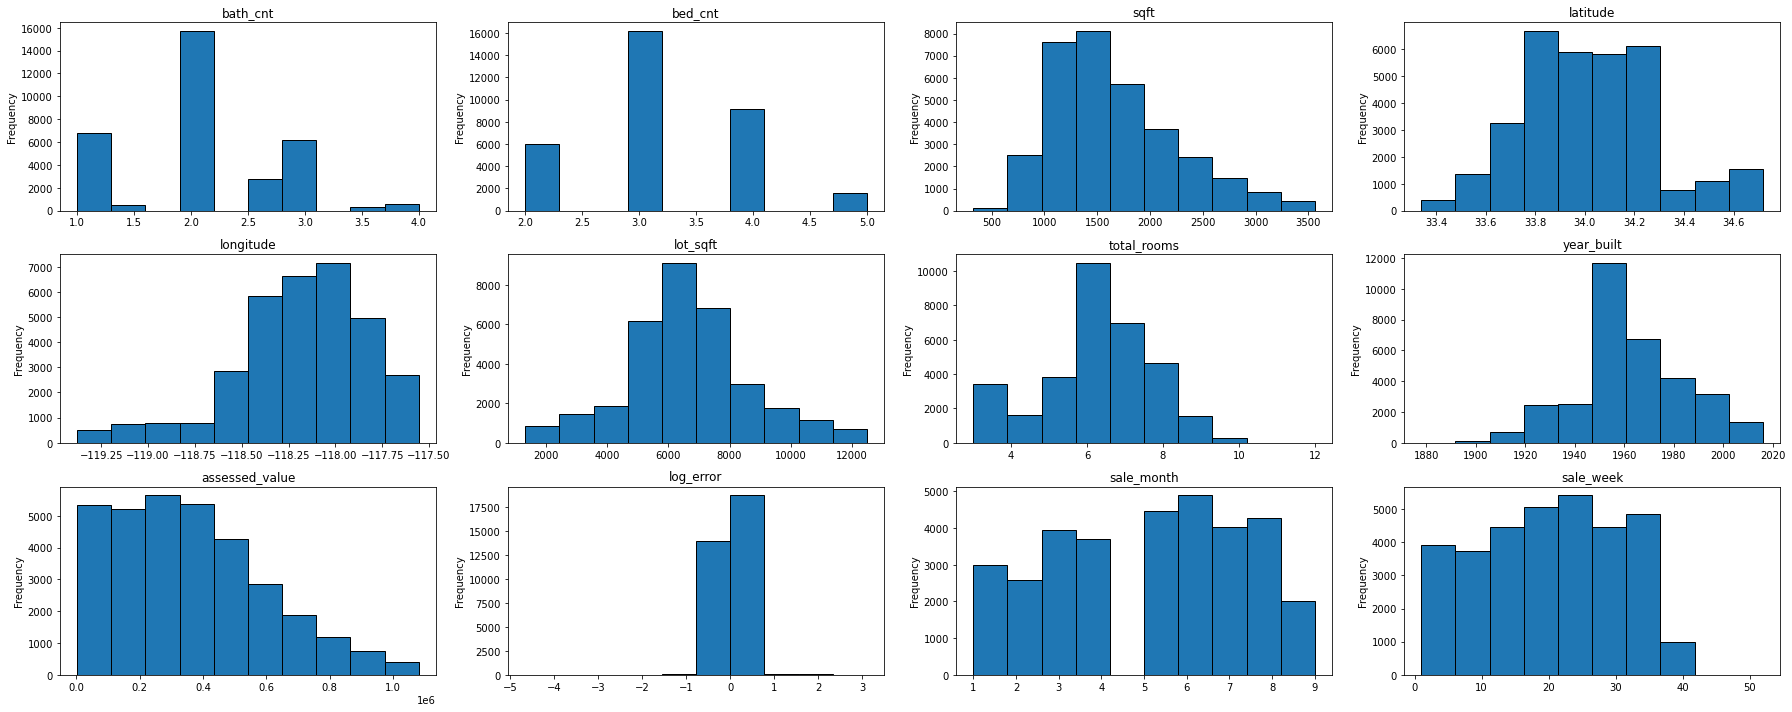

In [12]:
# let's take a look at the distributions of the continuous variables
fig, axs = plt.subplots(3, 4, sharey=False, figsize=(25, 10))
axe = axs.ravel()
for i, c in enumerate(train_exp.select_dtypes('number').columns):
    train_exp[c].plot.hist(ax=axe[i],title=c, ec='black')
    plt.tight_layout()

#### Takeaways:
- Some distributions look normal, some not as much
- Will use parametric and non-parametric tests accordingly

### Bivariate

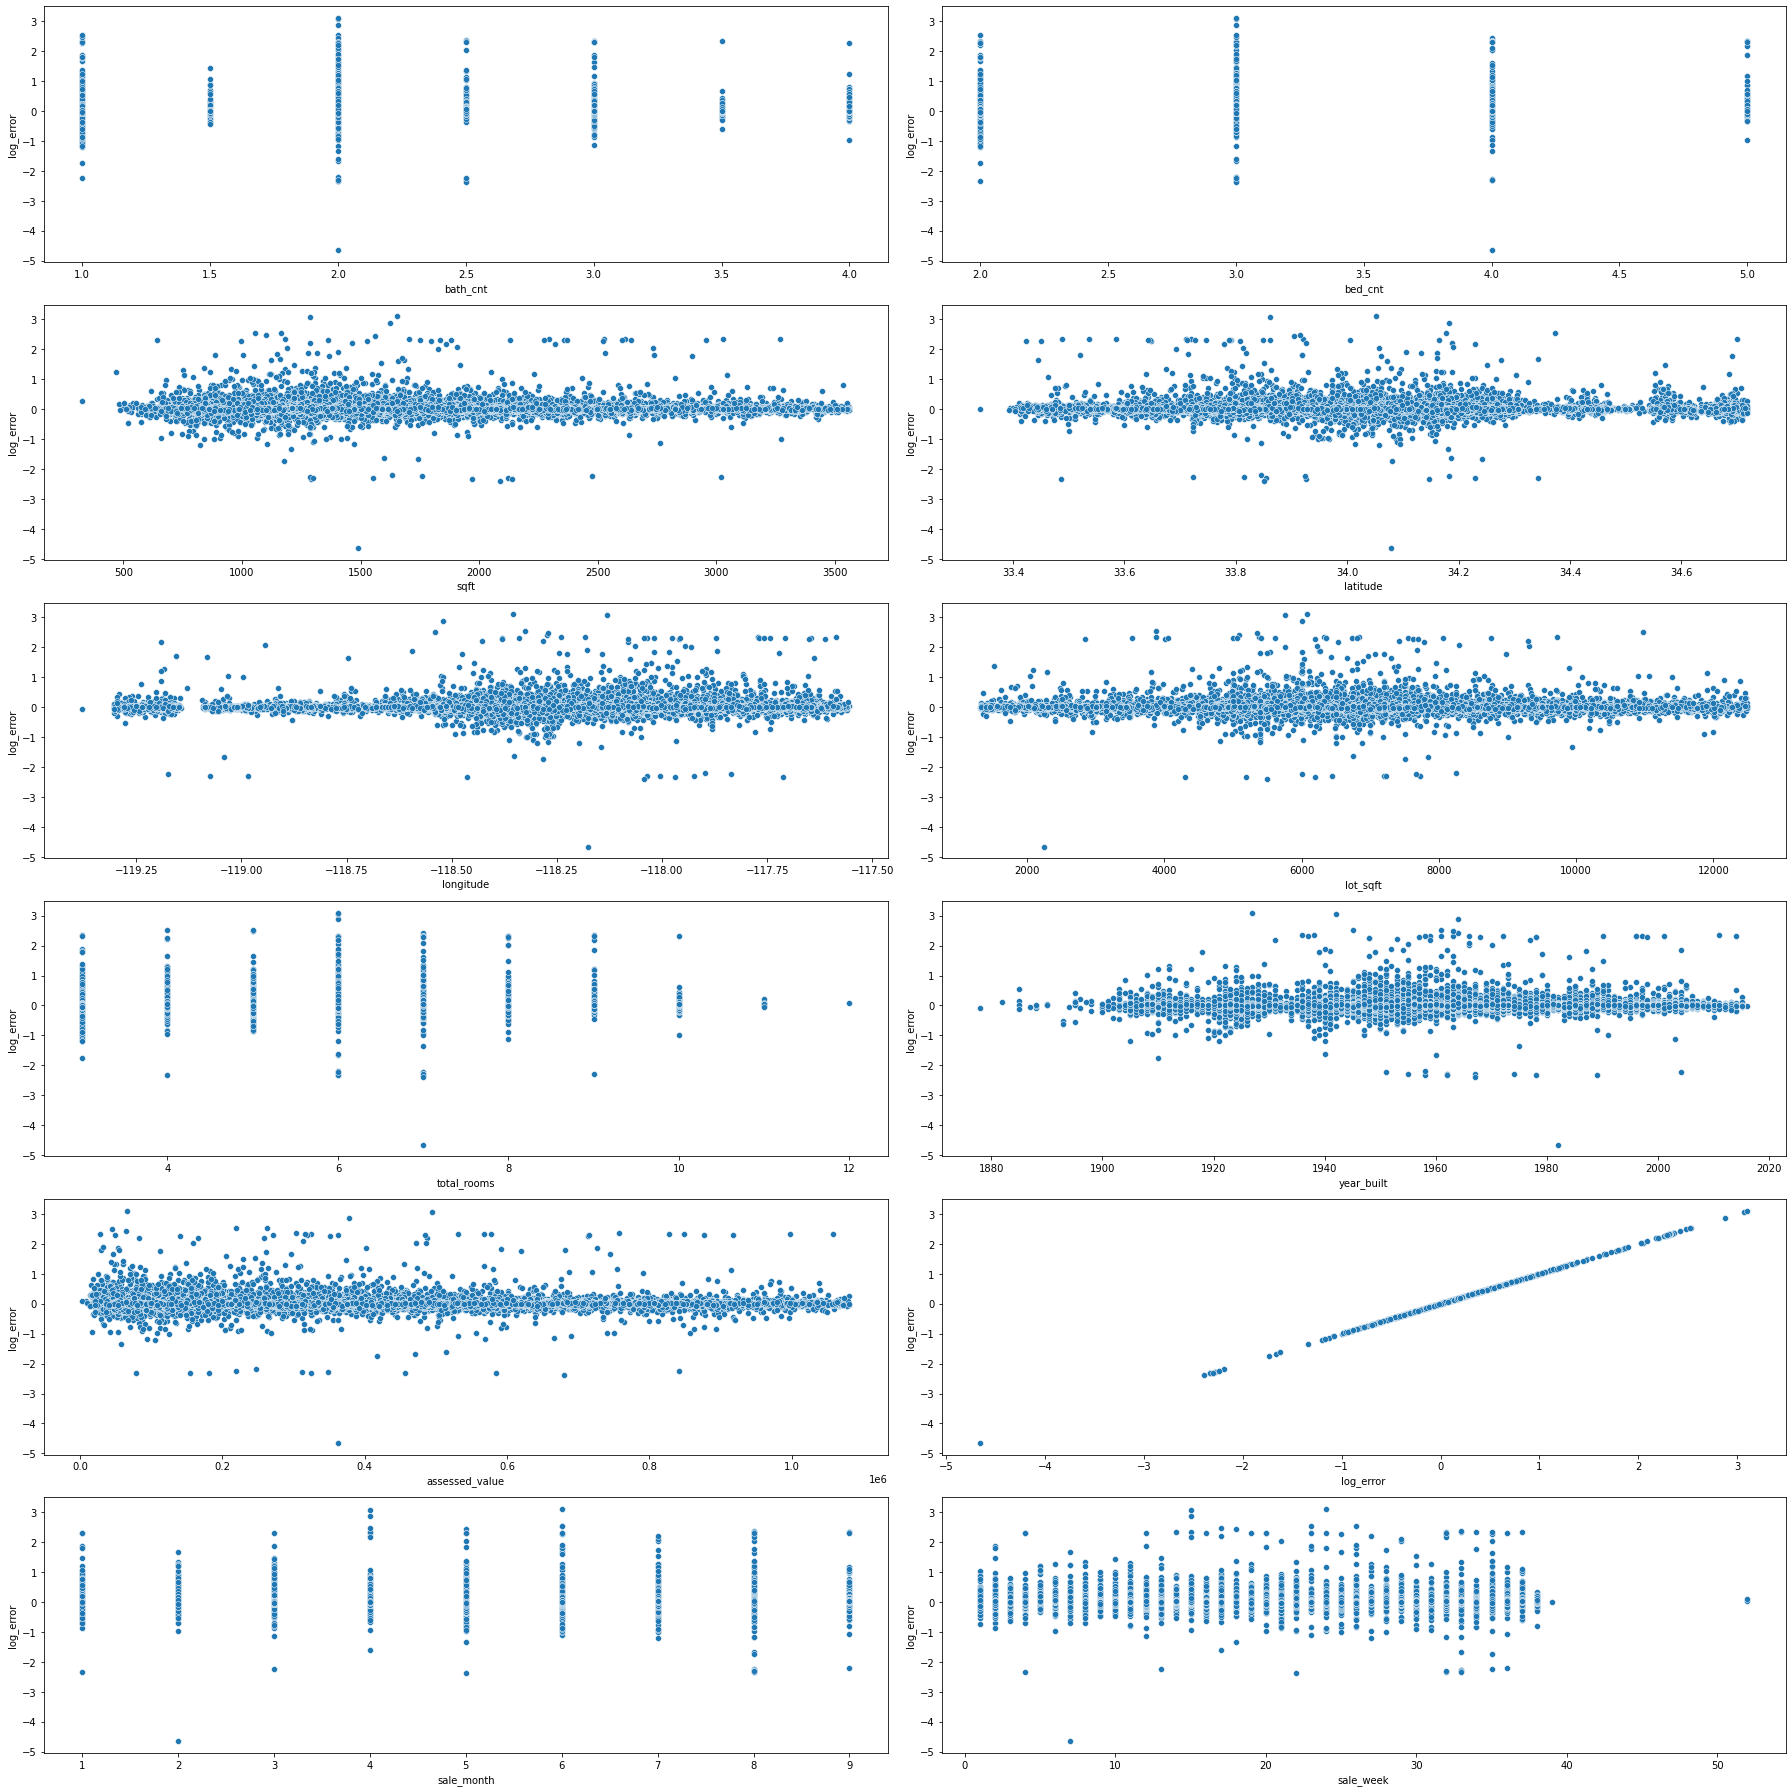

In [13]:
# let's take a look at all other continuous variables compared to target
fig, axs = plt.subplots(6, 2, sharey=False, figsize=(25, 25))
axe = axs.ravel()
for i, c in enumerate(train_exp.select_dtypes('number').columns):
    sns.scatterplot(x=train_exp[c], y=train_exp.log_error, ax=axe[i])
    plt.tight_layout()

#### Takeaways:
- There seems to be more error on smaller properties (< 2000 sf)
- There seems to be more error for smaller latitude (< 34.4$^{\circ}$ N)
- There seems to be more error for bigger longitude (> -118.5$^{\circ}$ W)
- There seems to be more error in mid-sized lots (between 5,000 and 8,000 sf)
- There are some groupings of larger error for year built (not easy to define ranges)
- Lower value homes seems to have more error (as house gets smaller, error seems to increase)
- We don't seems to have homes in our dataset that sold from Oct to Dec

### Multivariate

In [14]:
# plt.figure(figsize=(12, 12))
# heatmap = sns.heatmap(train_exp.corr(), annot=True, cmap='coolwarm_r', vmin=-1, vmax=1, center=0)
# heatmap.set_title('Correlation Heatmap for Predictors and Target', pad=16);

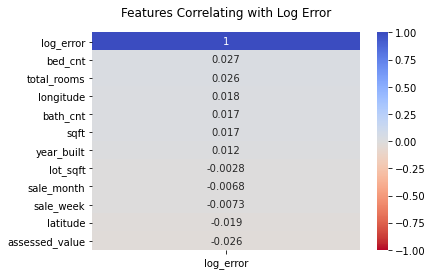

In [15]:
heatmap = sns.heatmap(train_exp.corr()[['log_error']].sort_values(by='log_error', ascending=False), annot=True, cmap='coolwarm_r', vmin=-1, vmax=1 );
heatmap.set_title('Features Correlating with Log Error', pad=16);

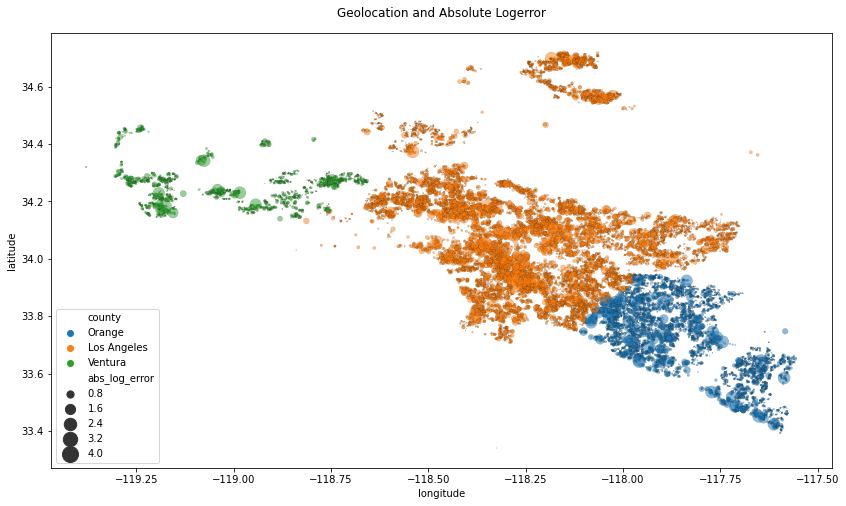

In [16]:
train_exp['abs_log_error'] = train_exp.log_error.apply(lambda x: x if x >= 0 else -x)
plt.figure(figsize=(14,8))
sns.scatterplot(x='longitude', y='latitude', hue='county', size='abs_log_error', sizes=(0,300), ec='black', linewidth=0.15, alpha=0.5, data=train_exp)
plt.legend()
plt.title('Geolocation and Absolute Logerror',  pad=16)
plt.show()

#### Takeaways:
- No variables are strongly correlated with target
- There appear to be some groupings of larger error in the plot of latitude, longitude, and log error

---
### Binning and One-Sample T Tests

1. Is logerror significantly different for properties in LA County vs Orange County vs Ventura County?

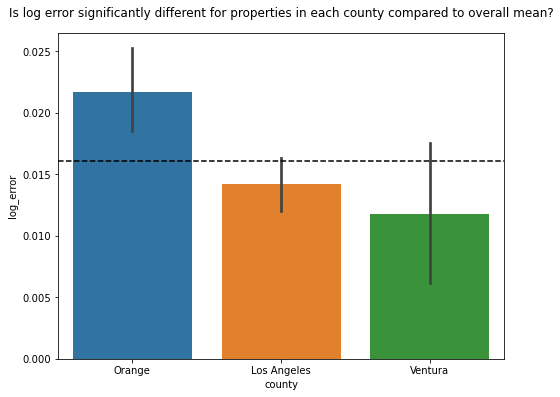

In [17]:
plt.figure(figsize=(8, 6))
sns.barplot(y=train_exp.log_error, x=train_exp.county)
plt.axhline(y=train_exp.log_error.mean(), ls='--', color='black')
plt.title('Is log error significantly different for properties in each county compared to overall mean?', pad=16);

**Hypotheses:**

$H_0$: there is no difference in log error for houses in different counties and the overall population mean

$H_a$: there is a difference in log error for houses in different counties and the overall population mean

In [18]:
e.group_stats(df=train_exp, target_col='log_error', group_by_col='county')

One-sample T-test Results for the Los Angeles subset:
T-Statistic: -1.73
P-value: 0.084
We fail to reject the null hypothesis, the mean log error for the Los Angeles subset is not different than the overall population mean.

One-sample T-test Results for the Orange subset:
T-Statistic: 3.16
P-value: 0.002
We reject the null hypothesis, the mean log error for the Orange subset is different than the overall population mean.

One-sample T-test Results for the Ventura subset:
T-Statistic: -1.51
P-value: 0.132
We fail to reject the null hypothesis, the mean log error for the Ventura subset is not different than the overall population mean.



***Takeaways:***
- Orange County subset has higher log error
- Including this category might improve model
- Might be more effective to create model this county on its own

---

2. Is sqft related to log error?

In [19]:
train_exp['sqft_bins'] = pd.cut(train_exp.sqft, [0, 1500, 2500, 4000])

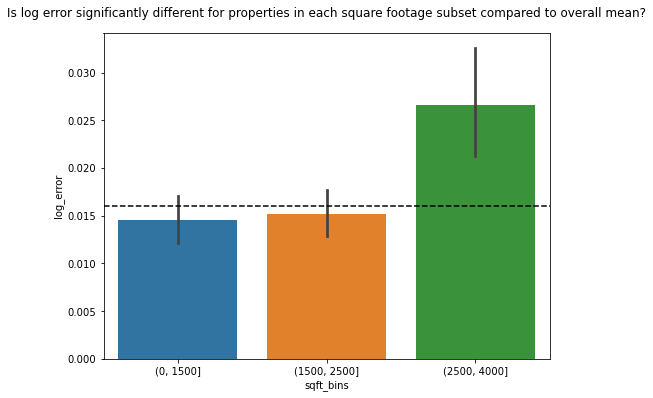

In [20]:
plt.figure(figsize=(8, 6))
sns.barplot(y=train_exp.log_error, x=train_exp.sqft_bins)
plt.axhline(y=train_exp.log_error.mean(), ls='--', color='black')
plt.title('Is log error significantly different for properties in each square footage subset compared to overall mean?', pad=16);

**Hypotheses:**

$H_0$: there is no difference in log error for houses in different square footage subsets and the overall population mean

$H_a$: there is a difference in log error for houses in different square footage subsets and the overall population mean

In [21]:
e.group_stats(df=train_exp, target_col='log_error', group_by_col='sqft_bins')

One-sample T-test Results for the (0, 1500] subset:
T-Statistic: -1.12
P-value: 0.263
We fail to reject the null hypothesis, the mean log error for the (0, 1500] subset is not different than the overall population mean.

One-sample T-test Results for the (1500, 2500] subset:
T-Statistic: -0.70
P-value: 0.486
We fail to reject the null hypothesis, the mean log error for the (1500, 2500] subset is not different than the overall population mean.

One-sample T-test Results for the (2500, 4000] subset:
T-Statistic: 3.64
P-value: 0.000
We reject the null hypothesis, the mean log error for the (2500, 4000] subset is different than the overall population mean.



***Takeaways:***
- 2500 - 4000 sqft subset has higher log error
- Including this category might improve model
- Might be more effective to create model for this subset on its own

---

3. Is assessed value related to log error?

In [22]:
train_exp['assessed_value_bins'] = pd.cut(train_exp.assessed_value, [0, 250_000, 500_000, 1_500_000])

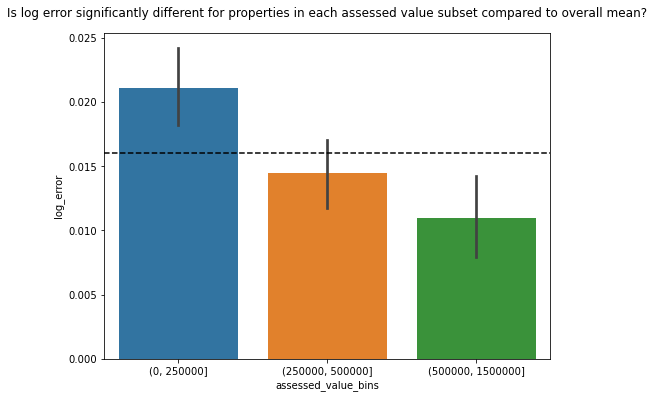

In [23]:
plt.figure(figsize=(8, 6))
sns.barplot(y=train_exp.log_error, x=train_exp.assessed_value_bins)
plt.axhline(y=train_exp.log_error.mean(), ls='--', color='black')
plt.title('Is log error significantly different for properties in each assessed value subset compared to overall mean?', pad=16);

**Hypotheses:**

$H_0$: there is no difference in log error for houses in different assessed value subsets and the overall population mean

$H_a$: there is a difference in log error for houses in different assessed value subsets and the overall population mean

In [24]:
e.group_stats(df=train_exp, target_col='log_error', group_by_col='assessed_value_bins')

One-sample T-test Results for the (0, 250000] subset:
T-Statistic: 3.30
P-value: 0.001
We reject the null hypothesis, the mean log error for the (0, 250000] subset is different than the overall population mean.

One-sample T-test Results for the (250000, 500000] subset:
T-Statistic: -1.11
P-value: 0.268
We fail to reject the null hypothesis, the mean log error for the (250000, 500000] subset is not different than the overall population mean.

One-sample T-test Results for the (500000, 1500000] subset:
T-Statistic: -3.16
P-value: 0.002
We reject the null hypothesis, the mean log error for the (500000, 1500000] subset is different than the overall population mean.



***Takeaways:***
- \$0 - 250k subset has higher log error
- $500k - 1.5m subset has lower log error
- Including these categories might improve model
- Might be more effective to create model for the \$0 - 250k subset on its own

---

4. Is year built related to log error?

In [25]:
train_exp['year_built_bins'] = pd.cut(train_exp.year_built, [0, 1950, 1970, 2020])

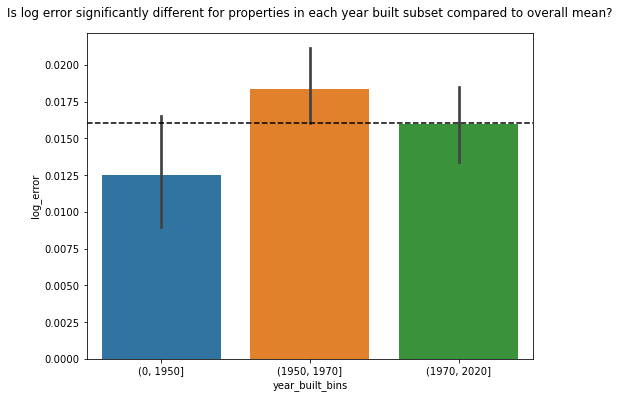

In [26]:
plt.figure(figsize=(8, 6))
sns.barplot(y=train_exp.log_error, x=train_exp.year_built_bins)
plt.axhline(y=train_exp.log_error.mean(), ls='--', color='black')
plt.title('Is log error significantly different for properties in each year built subset compared to overall mean?', pad=16);

**Hypotheses:**

$H_0$: there is no difference in log error for houses in different year built subsets and the overall population mean

$H_a$: there is a difference in log error for houses in different year built subsets and the overall population mean

In [27]:
e.group_stats(df=train_exp, target_col='log_error', group_by_col='year_built_bins')

One-sample T-test Results for the (0, 1950] subset:
T-Statistic: -1.82
P-value: 0.069
We fail to reject the null hypothesis, the mean log error for the (0, 1950] subset is not different than the overall population mean.

One-sample T-test Results for the (1950, 1970] subset:
T-Statistic: 1.75
P-value: 0.080
We fail to reject the null hypothesis, the mean log error for the (1950, 1970] subset is not different than the overall population mean.

One-sample T-test Results for the (1970, 2020] subset:
T-Statistic: -0.02
P-value: 0.981
We fail to reject the null hypothesis, the mean log error for the (1970, 2020] subset is not different than the overall population mean.



***Takeaways:***
- None of these subsets are different from mean

---

5. Is total rooms related to log error?

In [28]:
train_exp['total_room_bins'] = pd.cut(train_exp.total_rooms, [0, 5, 7, 12])

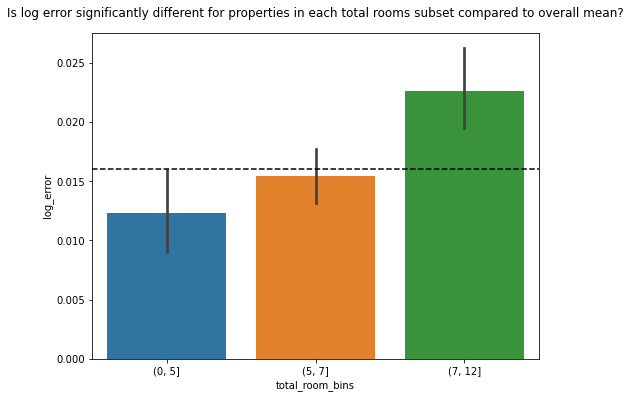

In [29]:
plt.figure(figsize=(8, 6))
sns.barplot(y=train_exp.log_error, x=train_exp.total_room_bins)
plt.axhline(y=train_exp.log_error.mean(), ls='--', color='black')
plt.title('Is log error significantly different for properties in each total rooms subset compared to overall mean?', pad=16);

**Hypotheses:**

$H_0$: there is no difference in log error for houses in different total rooms subsets and the overall population mean

$H_a$: there is a difference in log error for houses in different total rooms subsets and the overall population mean

In [30]:
e.group_stats(df=train_exp, target_col='log_error', group_by_col='total_room_bins')

One-sample T-test Results for the (0, 5] subset:
T-Statistic: -2.00
P-value: 0.045
We reject the null hypothesis, the mean log error for the (0, 5] subset is different than the overall population mean.

One-sample T-test Results for the (5, 7] subset:
T-Statistic: -0.49
P-value: 0.626
We fail to reject the null hypothesis, the mean log error for the (5, 7] subset is not different than the overall population mean.

One-sample T-test Results for the (7, 12] subset:
T-Statistic: 3.64
P-value: 0.000
We reject the null hypothesis, the mean log error for the (7, 12] subset is different than the overall population mean.



***Takeaways:***
- 7 - 12 subset has higher log error
- 0 - 5 subset has lower log error
- Including these categories might improve model
- Might be more effective to create model for the 7 - 12 subset on its own

---
### Encode, Scale, and Split for Clustering

In [85]:
# select columns to use for feature selection
mod_cols = df.select_dtypes('number').columns.tolist()
mod_cols.append('county')

df_modeling = df[mod_cols]

train_mod, val_mod, test_mod = w.encode_scale(df_modeling, MinMaxScaler(), 'log_error')

print(train_mod.shape, val_mod.shape, test_mod.shape)
print(train_mod.shape[0]/df.shape[0], val_mod.shape[0]/df.shape[0], test_mod.shape[0]/df.shape[0])

(32889, 18) (4066, 18) (4107, 18)
0.8009595246213044 0.09902099264526813 0.1000194827334275


---
### X and y

In [36]:
# split into X and y for all splits
X_train = train_mod.drop(columns='log_error')
y_train = train_mod.log_error
X_validate = val_mod.drop(columns='log_error')
y_validate = val_mod.log_error
X_test = test_mod.drop(columns='log_error')
y_test = test_mod.log_error

---
### Additional Feature Analysis

#### SelectKBest

In [37]:
len(X_train.columns)

14

In [38]:
e.select_kbest(X_train, y_train, 7)

['county_Orange',
 'bath_cnt_scaled',
 'bed_cnt_scaled',
 'latitude_scaled',
 'longitude_scaled',
 'total_rooms_scaled',
 'assessed_value_scaled']

#### RFE

In [39]:
e.show_rfe_feature_ranking(X_train, y_train)

county_Ventura            1
county_Los Angeles        2
county_Orange             3
assessed_value_scaled     4
sqft_scaled               5
latitude_scaled           6
sale_week_scaled          7
sale_month_scaled         8
bed_cnt_scaled            9
bath_cnt_scaled          10
lot_sqft_scaled          11
year_built_scaled        12
longitude_scaled         13
total_rooms_scaled       14
dtype: int64

### Explore Takeaways:
- Orange County has significantly higher log error compared to population and will be added to models
- Square footage bin of 2500 - 4000 has significantly higher log error compared to population and will be added to models
- Assessed value bin of \$0 - 250k has significantly higher log error compared to population and will be added to models
- Total rooms bin of 7 - 12 has significantly higher log error compared to population and will be added to models


---
## Explore using Clustering

---
### Cluster Model 1 - `total_rooms`, `sqft`, `assessed_value`

In [40]:
# lets take subset for clustering
X1 = X_train[['total_rooms_scaled', 'sqft_scaled', 'assessed_value_scaled']]

In [41]:
# plt.figure(figsize=(25, 7)).suptitle('Finding Ideal Number of Clusters (k)')

# kmax = 10

# plt.subplot(121)

# # let's plot inertia vs k for this model to chose number of clusters (k)

# pd.Series({k: KMeans(k).fit(X1).inertia_ for k in range(2, kmax+1)}).plot(marker='o')
# plt.xticks(range(2, kmax+1))
# plt.xlabel('k')
# plt.ylabel('Inertia')
# plt.title('Change in Inertia as k Increases for Cluster Model 1')


# plt.subplot(122)

# pd.Series({k: silhouette_score(X1, KMeans(k).fit(X1).labels_) for k in range(2, kmax+1)}).plot(marker='o')
# plt.xticks(range(2, kmax+1))
# plt.xlabel('k')
# plt.ylabel('Silhouette Score')
# plt.title('Change in Silhouette Score as k Increases for Cluster Model 1');

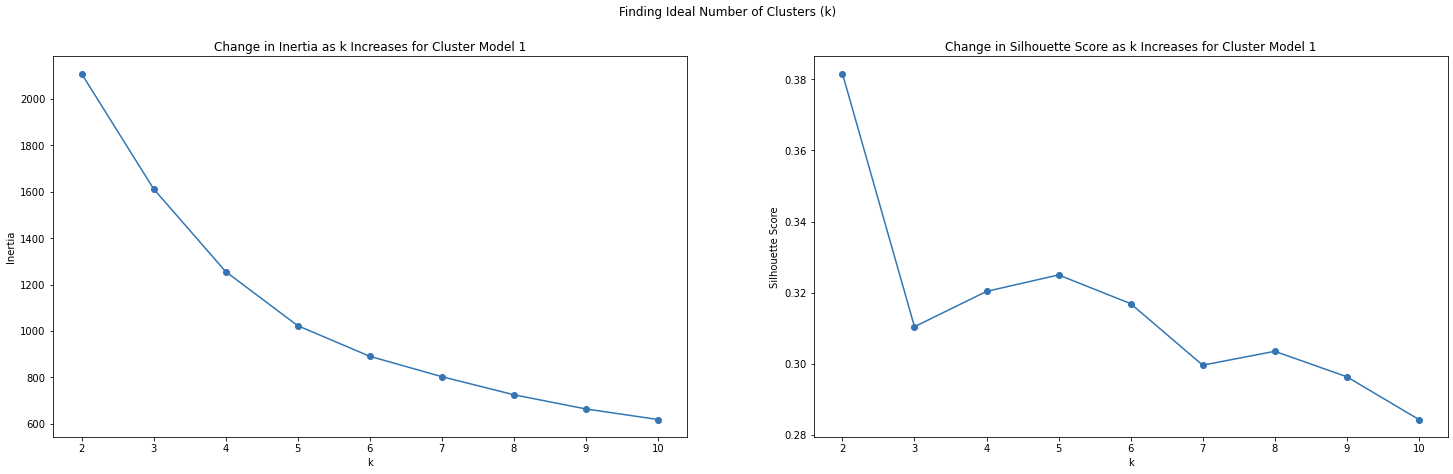

**Takeaway:**
- 5 clusters seems to be best based on Elbow Method and Silhouette Score

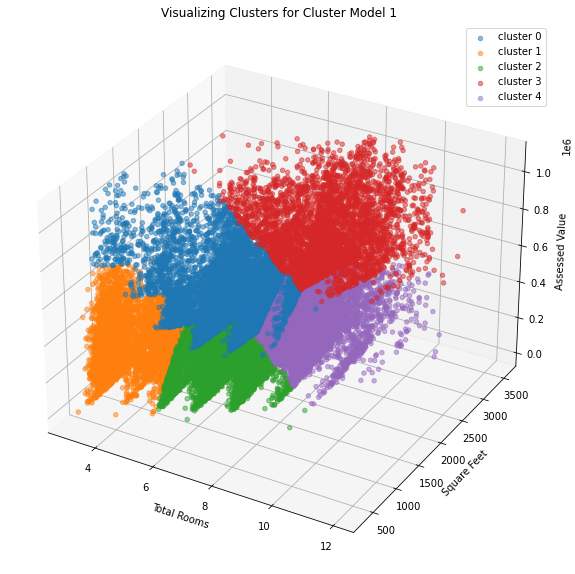

In [42]:
# create model object
kmeans1 = KMeans(n_clusters=5, random_state=527)

# fit the object to scaled, training data
kmeans1.fit(X1)

# Use (predict using) the thing 
train_exp['cluster_1'] = kmeans1.predict(X1)
X_train['cluster_1'] = kmeans1.predict(X1)

# 3d plots
plt.figure(figsize=(10, 10))

ax = plt.subplot(111, projection='3d')

for cluster, subset in train_exp.groupby('cluster_1'):
    ax.scatter(xs=subset.total_rooms, ys=subset.sqft, zs=subset.assessed_value, label='cluster ' + str(cluster), alpha=.5, cmap='reds')
plt.legend()
ax.set_xlabel('Total Rooms')
ax.set_ylabel('Square Feet')
ax.set_zlabel('Assessed Value')
plt.title('Visualizing Clusters for Cluster Model 1');

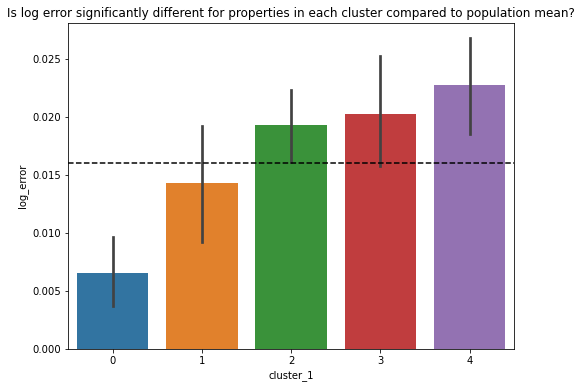

In [43]:
plt.figure(figsize=(8, 6))
sns.barplot(y=train_exp.log_error, x=train_exp.cluster_1)
plt.axhline(y=train_exp.log_error.mean(), ls='--', color='black')
plt.title('Is log error significantly different for properties in each cluster compared to population mean?');

**Hypotheses:**

$H_0$: there is no difference in log error for houses in different clusters

$H_a$: there is no difference in log error for houses in different clusters

In [44]:
e.cluster_stats(df=train_exp, target_col='log_error', group_by_col='cluster_1')

One-sample T-test Results for Cluster 0:
T-Statistic: -5.82
P-value: 0.000
We reject the null hypothesis, the mean log error for Cluster 0 is different than the overall population mean.

One-sample T-test Results for Cluster 1:
T-Statistic: -0.68
P-value: 0.499
We fail to reject the null hypothesis, the mean log error for for Cluster 1 is not different than the overall population mean.

One-sample T-test Results for Cluster 2:
T-Statistic: 2.09
P-value: 0.037
We reject the null hypothesis, the mean log error for Cluster 2 is different than the overall population mean.

One-sample T-test Results for Cluster 3:
T-Statistic: 1.73
P-value: 0.083
We fail to reject the null hypothesis, the mean log error for for Cluster 3 is not different than the overall population mean.

One-sample T-test Results for Cluster 4:
T-Statistic: 3.17
P-value: 0.002
We reject the null hypothesis, the mean log error for Cluster 4 is different than the overall population mean.



In [45]:
inertia1= kmeans1.inertia_
print(f'Inertia value for Cluster Model 1 is: {inertia1:.2f}')

Inertia value for Cluster Model 1 is: 1022.99


#### Takeaways:
- Clusters 0, 2, and 4 are drivers of log error
- Including these clusters as categories might improve model
- Might be more effective to create model for each cluster

---
### Cluster Model 2 - `latitude`, `longitude`, `assessed_value`

In [46]:
# lets take subset for clustering
X2 = X_train[['latitude_scaled', 'longitude_scaled', 'assessed_value_scaled']]

In [47]:
# plt.figure(figsize=(25, 7)).suptitle('Finding Ideal Number of Clusters (k)')

# kmax = 10

# plt.subplot(121)

# # let's plot inertia vs k for this model to chose number of clusters (k)

# pd.Series({k: KMeans(k).fit(X2).inertia_ for k in range(2, kmax+1)}).plot(marker='o')
# plt.xticks(range(2, kmax+1))
# plt.xlabel('k')
# plt.ylabel('Inertia')
# plt.title('Change in Inertia as k Increases for Cluster Model 2')


# plt.subplot(122)

# pd.Series({k: silhouette_score(X2, KMeans(k).fit(X2).labels_) for k in range(2, kmax+1)}).plot(marker='o')
# plt.xticks(range(2, kmax+1))
# plt.xlabel('k')
# plt.ylabel('Silhouette Score')
# plt.title('Change in Silhouette Score as k Increases for Cluster Model 2');

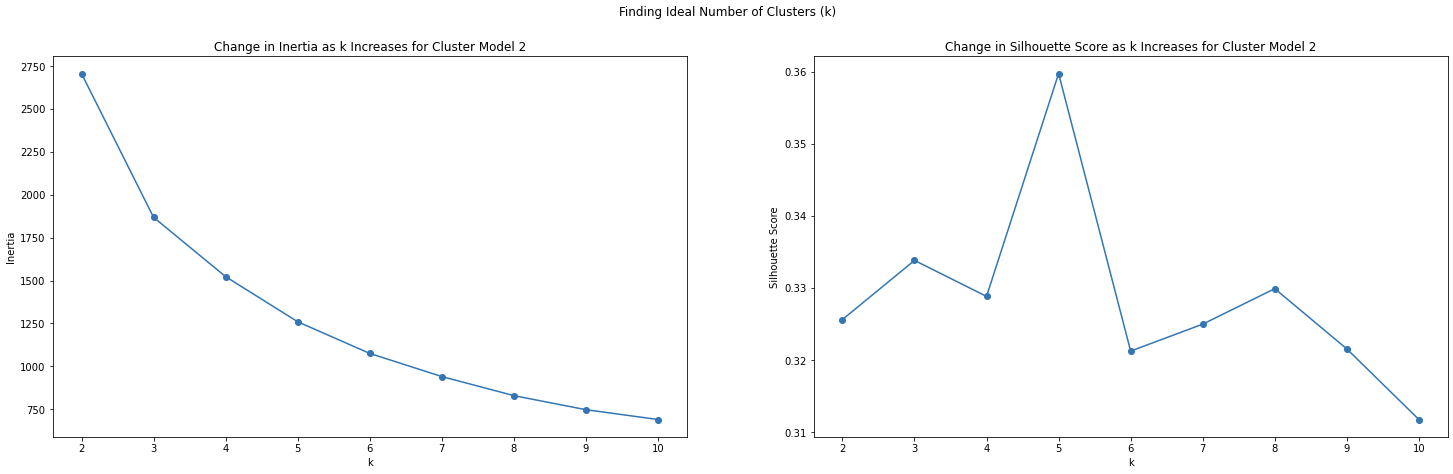

**Takeaway:**
- 5 clusters seems to be best based on Elbow Method and Silhouette Score

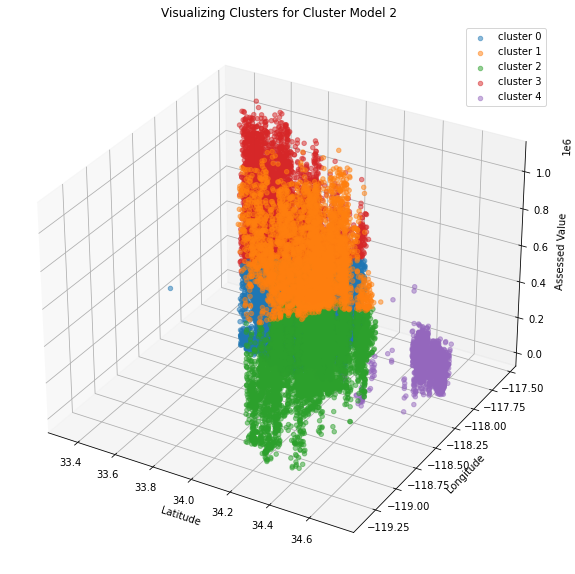

In [48]:
# create model object
kmeans2 = KMeans(n_clusters=5, random_state=527)

# fit the object to scaled, training data
kmeans2.fit(X2)

# Use (predict using) the thing 
train_exp['cluster_2'] = kmeans2.predict(X2)

# 3d plots
plt.figure(figsize=(10, 10))

ax = plt.subplot(111, projection='3d')

for cluster, subset in train_exp.groupby('cluster_2'):
    ax.scatter(xs=subset.latitude, ys=subset.longitude, zs=subset.assessed_value, label='cluster ' + str(cluster), alpha=.5, cmap='reds')
plt.legend()
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_zlabel('Assessed Value')
plt.title('Visualizing Clusters for Cluster Model 2');

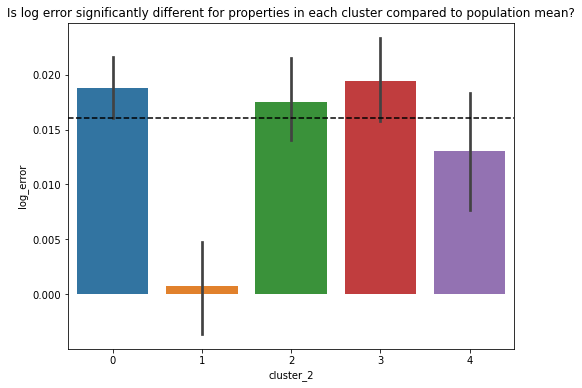

In [49]:
plt.figure(figsize=(8, 6))
sns.barplot(y=train_exp.log_error, x=train_exp.cluster_2)
plt.axhline(y=train_exp.log_error.mean(), ls='--', color='black')
plt.title('Is log error significantly different for properties in each cluster compared to population mean?');

**Hypotheses:**

$H_0$: there is no difference in mean log error for houses in different clusters and the mean log error for whole population

$H_a$: there is no difference in mean log error for houses in different clusters and the mean log error for whole population

In [50]:
e.cluster_stats(df=train_exp, target_col='log_error', group_by_col='cluster_2')

One-sample T-test Results for Cluster 0:
T-Statistic: 1.90
P-value: 0.057
We fail to reject the null hypothesis, the mean log error for for Cluster 0 is not different than the overall population mean.

One-sample T-test Results for Cluster 1:
T-Statistic: -7.27
P-value: 0.000
We reject the null hypothesis, the mean log error for Cluster 1 is different than the overall population mean.

One-sample T-test Results for Cluster 2:
T-Statistic: 0.76
P-value: 0.450
We fail to reject the null hypothesis, the mean log error for for Cluster 2 is not different than the overall population mean.

One-sample T-test Results for Cluster 3:
T-Statistic: 1.71
P-value: 0.087
We fail to reject the null hypothesis, the mean log error for for Cluster 3 is not different than the overall population mean.

One-sample T-test Results for Cluster 4:
T-Statistic: -1.09
P-value: 0.274
We fail to reject the null hypothesis, the mean log error for for Cluster 4 is not different than the overall population mean.



In [51]:
inertia2= kmeans2.inertia_
print(f'Inertia value for Cluster Model 2 is: {inertia2:.2f}')

Inertia value for Cluster Model 2 is: 1260.15


#### Takeaways:
- Cluster 1 is a driver of log error
- Including this cluster as a category might improve model
- Might be more effective to create model for this cluster

---
### Cluster Model 3 - `year_built`, `sqft`, `assessed_value`

In [52]:
X_train.head()

,county_Los Angeles,county_Orange,county_Ventura,bath_cnt_scaled,bed_cnt_scaled,sqft_scaled,latitude_scaled,longitude_scaled,lot_sqft_scaled,total_rooms_scaled,year_built_scaled,assessed_value_scaled,sale_month_scaled,sale_week_scaled,cluster_1
14152,0,1,0,0.666667,0.666667,0.582998,0.198456,0.806379,0.320841,0.444444,0.492754,0.124352,0.250,0.156863,4
46765,1,0,0,0.666667,0.666667,0.518083,0.617983,0.582991,0.536315,0.555556,0.456522,0.377235,0.625,0.450980,4
36185,0,1,0,0.333333,1.000000,0.511901,0.244310,0.781946,0.419231,0.555556,0.623188,0.307531,0.500,0.372549,4
52616,1,0,0,0.666667,1.000000,0.642968,0.951268,0.617890,0.778801,0.666667,0.862319,0.295752,0.625,0.490196,4
11667,0,1,0,0.333333,0.333333,0.221020,0.431610,0.796987,0.406708,0.333333,0.572464,0.341873,0.125,0.137255,0


In [53]:
# lets take subset for clustering
X3 = X_train[['year_built_scaled', 'sqft_scaled', 'assessed_value_scaled']]

In [54]:
# plt.figure(figsize=(25, 7)).suptitle('Finding Ideal Number of Clusters (k)')

# kmax = 10

# plt.subplot(121)

# # let's plot inertia vs k for this model to chose number of clusters (k)

# pd.Series({k: KMeans(k).fit(X3).inertia_ for k in range(2, kmax+1)}).plot(marker='o')
# plt.xticks(range(2, kmax+1))
# plt.xlabel('k')
# plt.ylabel('Inertia')
# plt.title('Change in Inertia as k Increases for Cluster Model 3')


# plt.subplot(122)

# pd.Series({k: silhouette_score(X3, KMeans(k).fit(X3).labels_) for k in range(2, kmax+1)}).plot(marker='o')
# plt.xticks(range(2, kmax+1))
# plt.xlabel('k')
# plt.ylabel('Silhouette Score')
# plt.title('Change in Silhouette Score as k Increases for Cluster Model 3');

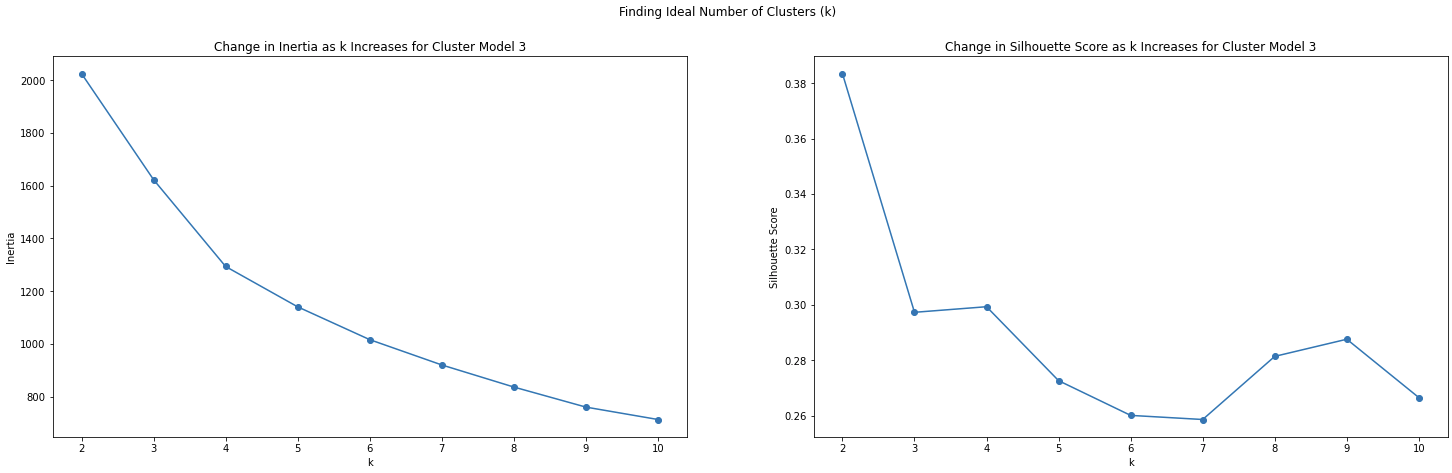

**Takeaway:**
- 4 clusters seems to be best based on Elbow Method and Silhouette Score

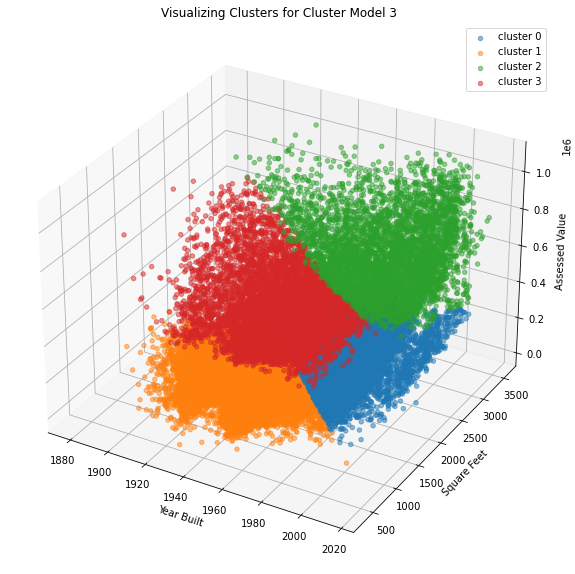

In [55]:
# create model object
kmeans3 = KMeans(n_clusters=4, random_state=527)

# fit the object to scaled, training data
kmeans3.fit(X3)

# Use (predict using) the thing 
train_exp['cluster_3'] = kmeans3.predict(X3)

# 3d plots
plt.figure(figsize=(10, 10))

ax = plt.subplot(111, projection='3d')

for cluster, subset in train_exp.groupby('cluster_3'):
    ax.scatter(xs=subset.year_built, ys=subset.sqft, zs=subset.assessed_value, label='cluster ' + str(cluster), alpha=.5, cmap='reds')
plt.legend()
ax.set_xlabel('Year Built')
ax.set_ylabel('Square Feet')
ax.set_zlabel('Assessed Value')
plt.title('Visualizing Clusters for Cluster Model 3');

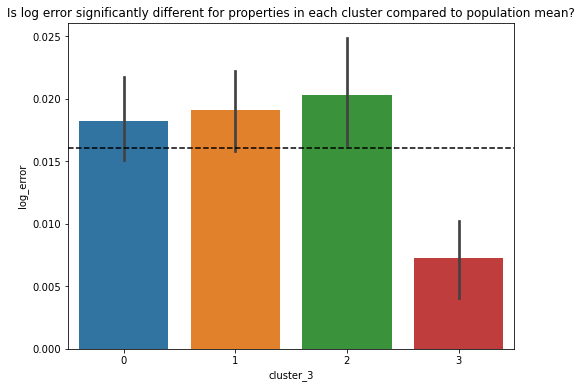

In [56]:
plt.figure(figsize=(8, 6))
sns.barplot(y=train_exp.log_error, x=train_exp.cluster_3)
plt.axhline(y=train_exp.log_error.mean(), ls='--', color='black')
plt.title('Is log error significantly different for properties in each cluster compared to population mean?');

**Hypotheses:**

$H_0$: there is no difference in mean log error for houses in different clusters and the mean log error for whole population

$H_a$: there is no difference in mean log error for houses in different clusters and the mean log error for whole population

In [57]:
e.cluster_stats(df=train_exp, target_col='log_error', group_by_col='cluster_3')

One-sample T-test Results for Cluster 0:
T-Statistic: 1.30
P-value: 0.193
We fail to reject the null hypothesis, the mean log error for for Cluster 0 is not different than the overall population mean.

One-sample T-test Results for Cluster 1:
T-Statistic: 1.92
P-value: 0.054
We fail to reject the null hypothesis, the mean log error for for Cluster 1 is not different than the overall population mean.

One-sample T-test Results for Cluster 2:
T-Statistic: 1.94
P-value: 0.052
We fail to reject the null hypothesis, the mean log error for for Cluster 2 is not different than the overall population mean.

One-sample T-test Results for Cluster 3:
T-Statistic: -5.66
P-value: 0.000
We reject the null hypothesis, the mean log error for Cluster 3 is different than the overall population mean.



In [58]:
inertia3= kmeans3.inertia_
print(f'Inertia value for Cluster Model 3 is: {inertia3:.2f}')

Inertia value for Cluster Model 3 is: 1293.66


#### Takeaways:
- Cluster 3 is a driver of log error
- Including this cluster as a category might improve model
- Might be more effective to create model for this cluster

### Explore with Clustering Takeaways:
- Cluster 4 from Cluster Model 1 has significantly higher log error compared to population and will be added to models (need to figure out how to get it back on df)

Add features to X and y as needed based on exploration findings

In [61]:
# add new features to original df, encode, split, and scale as necessary
df['_more_than_2500_sf'] = np.where(df.sqft > 2500, 1, 0)
df['_less_than_250k'] = np.where(df.assessed_value < 250_000, 1, 0)
df['_7_to_12_total_rooms'] = np.where(((df.total_rooms > 7) & (df.total_rooms <= 12)), 1, 0)
mod_cols_final =df.select_dtypes('number').columns.tolist()
mod_cols_final.append('county')
df_modeling_final = df[mod_cols_final]
cols_not_scale = [col for col in mod_cols_final if col.startswith('_')]
train_mod_final, val_mod_final, test_mod_final = w.encode_scale_final(df_modeling_final, MinMaxScaler(), 'log_error', cols_not_scale)

# add use cluser object to predict on original df and then encode
train_mod_final['cluster_1'] = kmeans1.predict(train_mod_final[['total_rooms_scaled', 'sqft_scaled', 'assessed_value_scaled']])
train_mod_final['_4_cluster_1'] = np.where(train_mod_final.cluster_1 == 4, 1, 0)
train_mod_final = train_mod_final.drop(columns='cluster_1')
val_mod_final['cluster_1'] = kmeans1.predict(val_mod_final[['total_rooms_scaled', 'sqft_scaled', 'assessed_value_scaled']])
val_mod_final['_4_cluster_1'] = np.where(val_mod_final.cluster_1 == 4, 1, 0)
val_mod_final = val_mod_final.drop(columns='cluster_1')
test_mod_final['cluster_1'] = kmeans1.predict(test_mod_final[['total_rooms_scaled', 'sqft_scaled', 'assessed_value_scaled']])
test_mod_final['_4_cluster_1'] = np.where(test_mod_final.cluster_1 == 4, 1, 0)
test_mod_final = test_mod_final.drop(columns='cluster_1')

# check shape
print(train_mod_final.shape, val_mod_final.shape, test_mod_final.shape)

(32889, 19) (4066, 19) (4107, 19)


---
## Model/Evaluate
---

### X and y

In [62]:
# split into X and y for all splits
X_train = train_mod_final.drop(columns='log_error')
y_train = train_mod_final.log_error
X_validate = val_mod_final.drop(columns='log_error')
y_validate = val_mod_final.log_error
X_test = test_mod_final.drop(columns='log_error')
y_test = test_mod_final.log_error

In [63]:
total = X_train.shape[0] + X_validate.shape[0] + X_test.shape[0]
print(f'Train Proportion: {(X_train.shape[0]/total):.2f}\nValidate Proportion: {(X_validate.shape[0]/total):.2f}\nTest Proportion: {(X_test.shape[0]/total):.2f}')

Train Proportion: 0.80
Validate Proportion: 0.10
Test Proportion: 0.10


### Target Distribution

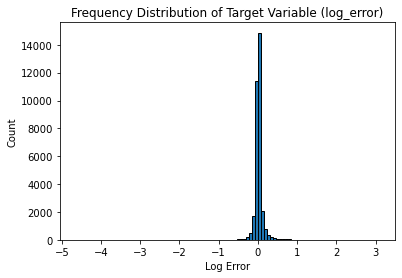

In [64]:
plt.hist(y_train, edgecolor='black', bins=100)
plt.title('Frequency Distribution of Target Variable (log_error)')
plt.xlabel('Log Error')
plt.ylabel('Count');

***Looks normal***

### Baseline

In [65]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# Predict baseline_mean
baseline_mean = y_train.log_error.mean()
y_train['baseline_mean'] = baseline_mean
y_validate['baseline_mean'] = baseline_mean

In [66]:
# create empty df to start appending to
metric_df = pd.DataFrame()

In [67]:
# get metrics for baseline mean model
metric_df = ev.make_metric_df(y_train.log_error, 
                           y_train.baseline_mean, 
                           y_validate.log_error, 
                           y_validate.baseline_mean, 
                           'baseline_mean', 
                           metric_df)
metric_df

,model,RMSE_train,RMSE_validate,RMSE_diff,R2_train,R2_validate,R2_diff
0,baseline_mean,0.159,0.169,-0.011,0.0,0.0,0.0


### LinearRegression (OLS)

In [68]:
# make model
ols = LinearRegression(normalize=True)

# fit model
ols.fit(X_train, y_train.log_error)

# Make prediction for train and validate
y_train['ols_y_pred'] = ols.predict(X_train)
y_validate['ols_y_pred'] = ols.predict(X_validate)

# get metrics
metric_df = ev.make_metric_df(y_train.log_error, 
                           y_train.ols_y_pred, 
                           y_validate.log_error, 
                           y_validate.ols_y_pred, 
                           'OLS', 
                           metric_df)
metric_df

,model,RMSE_train,RMSE_validate,RMSE_diff,R2_train,R2_validate,R2_diff
0,baseline_mean,0.159,0.169,-0.011,0.000,0.000,0.000
1,OLS,0.158,0.169,-0.011,0.003,0.002,0.002


### LassoLars

In [69]:
# create the model
lars = LassoLars(alpha=1)

# fit the model
lars.fit(X_train, y_train.log_error)

# predict train
y_train['lars_y_pred_alpha_1'] = lars.predict(X_train)

# predict validate
y_validate['lars_y_pred_alpha_1'] = lars.predict(X_validate)

# get metrics
metric_df = ev.make_metric_df(y_train.log_error, 
                           y_train.lars_y_pred_alpha_1, 
                           y_validate.log_error, 
                           y_validate.lars_y_pred_alpha_1, 
                           'lasso_alpha_1', 
                           metric_df)
metric_df

,model,RMSE_train,RMSE_validate,RMSE_diff,R2_train,R2_validate,R2_diff
0,baseline_mean,0.159,0.169,-0.011,0.000,0.000,0.000
1,OLS,0.158,0.169,-0.011,0.003,0.002,0.002
2,lasso_alpha_1,0.159,0.169,-0.011,0.000,0.000,0.000


In [70]:
# create the model
lars = LassoLars(alpha=2)

# fit the model
lars.fit(X_train, y_train.log_error)

# predict train
y_train['lars_y_pred_alpha_2'] = lars.predict(X_train)

# predict validate
y_validate['lars_y_pred_alpha_2'] = lars.predict(X_validate)

# get metrics
metric_df = ev.make_metric_df(y_train.log_error, 
                           y_train.lars_y_pred_alpha_2, 
                           y_validate.log_error, 
                           y_validate.lars_y_pred_alpha_2, 
                           'lasso_alpha_2', 
                           metric_df)
metric_df

,model,RMSE_train,RMSE_validate,RMSE_diff,R2_train,R2_validate,R2_diff
0,baseline_mean,0.159,0.169,-0.011,0.000,0.000,0.000
1,OLS,0.158,0.169,-0.011,0.003,0.002,0.002
2,lasso_alpha_1,0.159,0.169,-0.011,0.000,0.000,0.000
3,lasso_alpha_2,0.159,0.169,-0.011,0.000,0.000,0.000


In [71]:
# create the model
lars = LassoLars(alpha=3)

# fit the model
lars.fit(X_train, y_train.log_error)

# predict train
y_train['lars_y_pred_alpha_3'] = lars.predict(X_train)

# predict validate
y_validate['lars_y_pred_alpha_3'] = lars.predict(X_validate)

# get metrics
metric_df = ev.make_metric_df(y_train.log_error, 
                           y_train.lars_y_pred_alpha_3, 
                           y_validate.log_error, 
                           y_validate.lars_y_pred_alpha_3, 
                           'lasso_alpha_3', 
                           metric_df)
metric_df

,model,RMSE_train,RMSE_validate,RMSE_diff,R2_train,R2_validate,R2_diff
0,baseline_mean,0.159,0.169,-0.011,0.000,0.000,0.000
1,OLS,0.158,0.169,-0.011,0.003,0.002,0.002
2,lasso_alpha_1,0.159,0.169,-0.011,0.000,0.000,0.000
3,lasso_alpha_2,0.159,0.169,-0.011,0.000,0.000,0.000
4,lasso_alpha_3,0.159,0.169,-0.011,0.000,0.000,0.000


###  TweedieRegressor (GLM)

In [72]:
# create the model
glm = TweedieRegressor(power=0, alpha=0)

# fit the model
glm.fit(X_train, y_train.log_error)

# predict train
y_train['glm_y_pred_normal'] = glm.predict(X_train)

# predict validate
y_validate['glm_y_pred_normal'] = glm.predict(X_validate)

# get metrics
metric_df = ev.make_metric_df(y_train.log_error, 
                           y_train.glm_y_pred_normal, 
                           y_validate.log_error, 
                           y_validate.glm_y_pred_normal, 
                           'glm_normal', 
                           metric_df)
metric_df

,model,RMSE_train,RMSE_validate,RMSE_diff,R2_train,R2_validate,R2_diff
0,baseline_mean,0.159,0.169,-0.011,0.000,0.000,0.000
1,OLS,0.158,0.169,-0.011,0.003,0.002,0.002
2,lasso_alpha_1,0.159,0.169,-0.011,0.000,0.000,0.000
3,lasso_alpha_2,0.159,0.169,-0.011,0.000,0.000,0.000
4,lasso_alpha_3,0.159,0.169,-0.011,0.000,0.000,0.000
5,glm_normal,0.158,0.169,-0.011,0.003,0.002,0.001


### Polynomial Regression

#### PolynomialFeatures

In [73]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate
X_validate_degree2 = pf.transform(X_validate)

In [74]:
# make the polynomial features to get a new set of features
pf3 = PolynomialFeatures(degree=3)

# fit and transform X_train
X_train_degree3 = pf3.fit_transform(X_train)

# transform X_validate
X_validate_degree3 = pf3.transform(X_validate)

#### LinearRegression

In [75]:
# create the model
lm2 = LinearRegression(normalize=True)

# fit the model
lm2.fit(X_train_degree2, y_train.log_error)

# predict train
y_train['lm2_y_pred'] = lm2.predict(X_train_degree2)

# predict validate
y_validate['lm2_y_pred'] = lm2.predict(X_validate_degree2)

# get metrics
metric_df = ev.make_metric_df(y_train.log_error, 
                           y_train.lm2_y_pred, 
                           y_validate.log_error, 
                           y_validate.lm2_y_pred, 
                           'lm2', 
                           metric_df)
metric_df

,model,RMSE_train,RMSE_validate,RMSE_diff,R2_train,R2_validate,R2_diff
0,baseline_mean,0.159,0.169,-0.011,0.000,0.000,0.000
1,OLS,0.158,0.169,-0.011,0.003,0.002,0.002
2,lasso_alpha_1,0.159,0.169,-0.011,0.000,0.000,0.000
3,lasso_alpha_2,0.159,0.169,-0.011,0.000,0.000,0.000
4,lasso_alpha_3,0.159,0.169,-0.011,0.000,0.000,0.000
5,glm_normal,0.158,0.169,-0.011,0.003,0.002,0.001
6,lm2,0.158,0.170,-0.012,0.012,-0.003,0.015


### Residual Plots

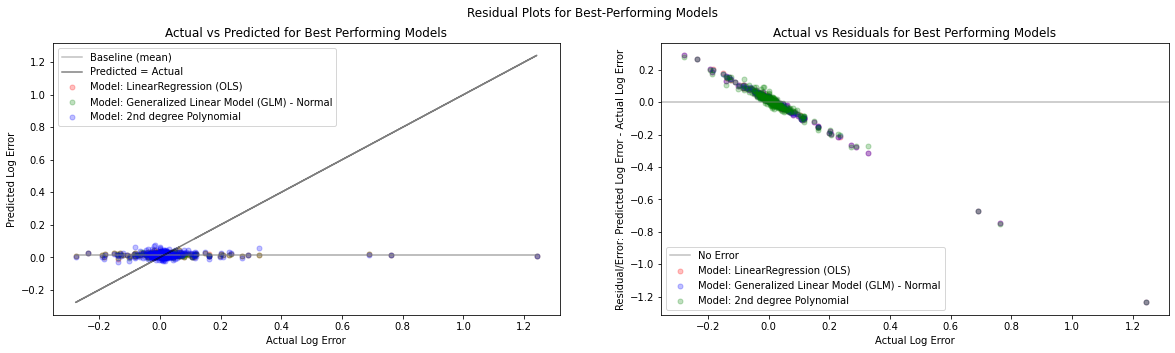

In [78]:
# create residual plots
# ols_y_pred, glm_y_pred_normal, lm2_y_pred

plt.figure(figsize=(20,5)).suptitle('Residual Plots for Best-Performing Models')

plt.subplot(121)

plt.plot(y_validate.log_error.sample(n=250, random_state=527), y_validate.baseline_mean.sample(n=250, random_state=527), alpha=0.5, color="gray", label='Baseline (mean)')
plt.plot(y_validate.log_error.sample(n=250, random_state=527), y_validate.log_error.sample(n=250, random_state=527), alpha=0.5, color="black", label='Predicted = Actual')

plt.scatter(y_validate.log_error.sample(n=250, random_state=527), y_validate.ols_y_pred.sample(n=250, random_state=527), 
            alpha=.25, color="red", s=25, label="Model: LinearRegression (OLS)")
plt.scatter(y_validate.log_error.sample(n=250, random_state=527), y_validate.glm_y_pred_normal.sample(n=250, random_state=527), 
            alpha=.25, color="green", s=25, label="Model: Generalized Linear Model (GLM) - Normal")
plt.scatter(y_validate.log_error.sample(n=250, random_state=527), y_validate.lm2_y_pred.sample(n=250, random_state=527), 
            alpha=.25, color="blue", s=25, label="Model: 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Log Error")
plt.ylabel("Predicted Log Error")
plt.title("Actual vs Predicted for Best Performing Models")

plt.subplot(122)

plt.axhline(label="No Error", color='gray', alpha=0.5)
plt.scatter(y_validate.log_error.sample(n=250, random_state=527), (y_validate.ols_y_pred - y_validate.log_error).sample(n=250, random_state=527), 
            alpha=.25, color="red", s=25, label="Model: LinearRegression (OLS)")
plt.scatter(y_validate.log_error.sample(n=250, random_state=527), (y_validate.glm_y_pred_normal - y_validate.log_error).sample(n=250, random_state=527), 
            alpha=.25, color="blue", s=25, label="Model: Generalized Linear Model (GLM) - Normal")
plt.scatter(y_validate.log_error.sample(n=250, random_state=527), (y_validate.lm2_y_pred - y_validate.log_error).sample(n=250, random_state=527), 
            alpha=.25, color="green", s=25, label="Model: 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Log Error")
plt.ylabel("Residual/Error: Predicted Log Error - Actual Log Error")
plt.title("Actual vs Residuals for Best Performing Models");

### Evaluate Best-Performing Model (GLM Normal) on Test

In [79]:
y_test = pd.DataFrame(y_test)
y_test['baseline_mean'] = y_train.log_error.mean()

# predict on test
y_test['glm_y_pred_normal'] = glm.predict(X_test)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.log_error, y_test.glm_y_pred_normal, squared=False)
r2_test = explained_variance_score(y_test.log_error, y_test.glm_y_pred_normal)

print(f'RMSE for GLM Normal\nOut-of-Sample Performance: {rmse_test:.2f}\nR^2: {r2_test:.3f}')

RMSE for GLM Normal
Out-of-Sample Performance: 0.17
R^2: 0.002


**Compare to Baseline:**

In [82]:
print(f'Model outperformed best baseline:\nRMSE difference: {(mean_squared_error(y_test.log_error, y_test.baseline_mean, squared=False) - rmse_test):.4f}\nR^2 difference: \
{(r2_test - explained_variance_score(y_test.log_error, y_test.baseline_mean)):.3f}')

Model outperformed best baseline:
RMSE difference: 0.0002
R^2 difference: 0.002


## Conclusions and Next Steps

**Results:**
- Best predictors discovered were bedroom count, number of bedrooms, number of bathrooms, and square footage
- Best-peforming model outperformed baseline and increased $R^2$ value by 0.2%

**Next Steps:**
- Try more feature combinations for clustering
    - More than 3 features
- Try more feature combinations in models

In [90]:
X_train.head()

,_more_than_2500_sf,_less_than_250k,_7_to_12_total_rooms,county_Los Angeles,county_Orange,county_Ventura,bath_cnt_scaled,bed_cnt_scaled,sqft_scaled,latitude_scaled,longitude_scaled,lot_sqft_scaled,total_rooms_scaled,year_built_scaled,assessed_value_scaled,sale_month_scaled,sale_week_scaled,_4_cluster_1
14152,0,1,0,0,1,0,0.666667,0.666667,0.582998,0.198456,0.806379,0.320841,0.444444,0.492754,0.124352,0.250,0.156863,1
46765,0,0,1,1,0,0,0.666667,0.666667,0.518083,0.617983,0.582991,0.536315,0.555556,0.456522,0.377235,0.625,0.450980,1
36185,0,0,1,0,1,0,0.333333,1.000000,0.511901,0.244310,0.781946,0.419231,0.555556,0.623188,0.307531,0.500,0.372549,1
52616,0,0,1,1,0,0,0.666667,1.000000,0.642968,0.951268,0.617890,0.778801,0.666667,0.862319,0.295752,0.625,0.490196,1
11667,0,0,0,0,1,0,0.333333,0.333333,0.221020,0.431610,0.796987,0.406708,0.333333,0.572464,0.341873,0.125,0.137255,0


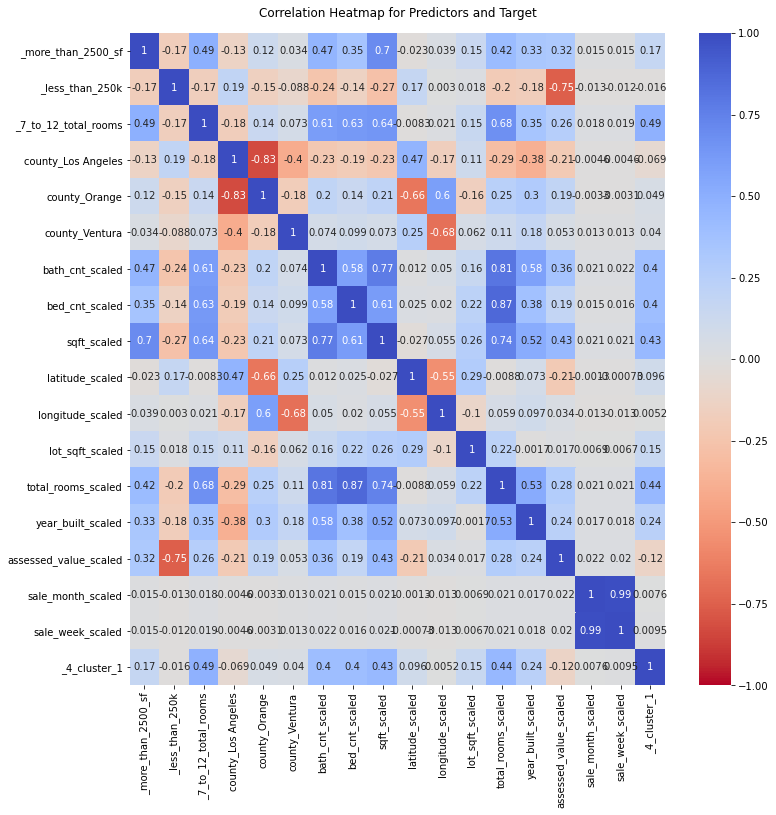

In [91]:
plt.figure(figsize=(12, 12))
heatmap = sns.heatmap(X_train.corr(), annot=True, cmap='coolwarm_r', vmin=-1, vmax=1, center=0)
heatmap.set_title('Correlation Heatmap for Predictors and Target', pad=16);

In [87]:
coef = pd.DataFrame(data={'glm_coef' : glm.coef_}, index = X_train.columns)
coef['abs_glm_coef'] = coef.glm_coef.apply(lambda x: x if x >= 0 else -x)

In [89]:
coef.sort_values(by='abs_glm_coef', ascending=False)

,glm_coef,abs_glm_coef
assessed_value_scaled,-0.025283,0.025283
latitude_scaled,-0.015975,0.015975
bed_cnt_scaled,0.013124,0.013124
_more_than_2500_sf,0.012593,0.012593
total_rooms_scaled,0.006680,0.006680
lot_sqft_scaled,-0.004717,0.004717
sqft_scaled,-0.004578,0.004578
_less_than_250k,0.003722,0.003722
longitude_scaled,0.003431,0.003431
county_Orange,0.003179,0.003179


---
## Model/Evaluate
---

In [92]:
train_mod_final.head()

,log_error,_more_than_2500_sf,_less_than_250k,_7_to_12_total_rooms,county_Los Angeles,county_Orange,county_Ventura,bath_cnt_scaled,bed_cnt_scaled,sqft_scaled,latitude_scaled,longitude_scaled,lot_sqft_scaled,total_rooms_scaled,year_built_scaled,assessed_value_scaled,sale_month_scaled,sale_week_scaled,_4_cluster_1
14152,0.034114,0,1,0,0,1,0,0.666667,0.666667,0.582998,0.198456,0.806379,0.320841,0.444444,0.492754,0.124352,0.250,0.156863,1
46765,-0.047764,0,0,1,1,0,0,0.666667,0.666667,0.518083,0.617983,0.582991,0.536315,0.555556,0.456522,0.377235,0.625,0.450980,1
36185,-0.019793,0,0,1,0,1,0,0.333333,1.000000,0.511901,0.244310,0.781946,0.419231,0.555556,0.623188,0.307531,0.500,0.372549,1
52616,-0.015435,0,0,1,1,0,0,0.666667,1.000000,0.642968,0.951268,0.617890,0.778801,0.666667,0.862319,0.295752,0.625,0.490196,1
11667,-0.041416,0,0,0,0,1,0,0.333333,0.333333,0.221020,0.431610,0.796987,0.406708,0.333333,0.572464,0.341873,0.125,0.137255,0


### X and y

In [174]:
# split into X and y for all splits
cols_to_include = ['assessed_value_scaled', 'latitude_scaled', 'sqft_scaled', 'sale_week_scaled', 'year_built_scaled']

X_train = train_mod_final[cols_to_include]
y_train = train_mod_final.log_error
X_validate = val_mod_final[cols_to_include]
y_validate = val_mod_final.log_error
X_test = test_mod_final[cols_to_include]
y_test = test_mod_final.log_error

In [175]:
total = X_train.shape[0] + X_validate.shape[0] + X_test.shape[0]
print(f'Train Proportion: {(X_train.shape[0]/total):.2f}\nValidate Proportion: {(X_validate.shape[0]/total):.2f}\nTest Proportion: {(X_test.shape[0]/total):.2f}')

Train Proportion: 0.80
Validate Proportion: 0.10
Test Proportion: 0.10


### Target Distribution

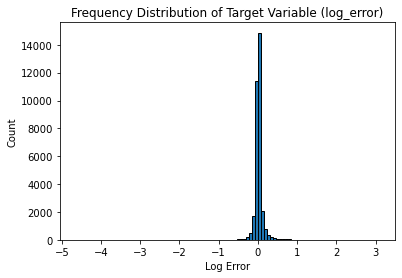

In [176]:
plt.hist(y_train, edgecolor='black', bins=100)
plt.title('Frequency Distribution of Target Variable (log_error)')
plt.xlabel('Log Error')
plt.ylabel('Count');

***Looks normal***

### Baseline

In [177]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# Predict baseline_mean
baseline_mean = y_train.log_error.mean()
y_train['baseline_mean'] = baseline_mean
y_validate['baseline_mean'] = baseline_mean

In [178]:
# create empty df to start appending to
metric_df = pd.DataFrame()

In [179]:
# get metrics for baseline mean model
metric_df = ev.make_metric_df(y_train.log_error, 
                           y_train.baseline_mean, 
                           y_validate.log_error, 
                           y_validate.baseline_mean, 
                           'baseline_mean', 
                           metric_df)
metric_df

,model,RMSE_train,RMSE_validate,RMSE_diff,R2_train,R2_validate,R2_diff
0,baseline_mean,0.159,0.169,-0.011,0.0,0.0,0.0


### LinearRegression (OLS)

In [180]:
# make model
ols = LinearRegression(normalize=True)

# fit model
ols.fit(X_train, y_train.log_error)

# Make prediction for train and validate
y_train['ols_y_pred'] = ols.predict(X_train)
y_validate['ols_y_pred'] = ols.predict(X_validate)

# get metrics
metric_df = ev.make_metric_df(y_train.log_error, 
                           y_train.ols_y_pred, 
                           y_validate.log_error, 
                           y_validate.ols_y_pred, 
                           'OLS', 
                           metric_df)
metric_df

,model,RMSE_train,RMSE_validate,RMSE_diff,R2_train,R2_validate,R2_diff
0,baseline_mean,0.159,0.169,-0.011,0.000,0.000,0.0
1,OLS,0.158,0.169,-0.011,0.002,0.002,0.0


### LassoLars

In [181]:
# create the model
lars = LassoLars(alpha=1)

# fit the model
lars.fit(X_train, y_train.log_error)

# predict train
y_train['lars_y_pred_alpha_1'] = lars.predict(X_train)

# predict validate
y_validate['lars_y_pred_alpha_1'] = lars.predict(X_validate)

# get metrics
metric_df = ev.make_metric_df(y_train.log_error, 
                           y_train.lars_y_pred_alpha_1, 
                           y_validate.log_error, 
                           y_validate.lars_y_pred_alpha_1, 
                           'lasso_alpha_1', 
                           metric_df)
metric_df

,model,RMSE_train,RMSE_validate,RMSE_diff,R2_train,R2_validate,R2_diff
0,baseline_mean,0.159,0.169,-0.011,0.000,0.000,0.0
1,OLS,0.158,0.169,-0.011,0.002,0.002,0.0
2,lasso_alpha_1,0.159,0.169,-0.011,0.000,0.000,0.0


In [182]:
# create the model
lars = LassoLars(alpha=2)

# fit the model
lars.fit(X_train, y_train.log_error)

# predict train
y_train['lars_y_pred_alpha_2'] = lars.predict(X_train)

# predict validate
y_validate['lars_y_pred_alpha_2'] = lars.predict(X_validate)

# get metrics
metric_df = ev.make_metric_df(y_train.log_error, 
                           y_train.lars_y_pred_alpha_2, 
                           y_validate.log_error, 
                           y_validate.lars_y_pred_alpha_2, 
                           'lasso_alpha_2', 
                           metric_df)
metric_df

,model,RMSE_train,RMSE_validate,RMSE_diff,R2_train,R2_validate,R2_diff
0,baseline_mean,0.159,0.169,-0.011,0.000,0.000,0.0
1,OLS,0.158,0.169,-0.011,0.002,0.002,0.0
2,lasso_alpha_1,0.159,0.169,-0.011,0.000,0.000,0.0
3,lasso_alpha_2,0.159,0.169,-0.011,0.000,0.000,0.0


In [183]:
# create the model
lars = LassoLars(alpha=3)

# fit the model
lars.fit(X_train, y_train.log_error)

# predict train
y_train['lars_y_pred_alpha_3'] = lars.predict(X_train)

# predict validate
y_validate['lars_y_pred_alpha_3'] = lars.predict(X_validate)

# get metrics
metric_df = ev.make_metric_df(y_train.log_error, 
                           y_train.lars_y_pred_alpha_3, 
                           y_validate.log_error, 
                           y_validate.lars_y_pred_alpha_3, 
                           'lasso_alpha_3', 
                           metric_df)
metric_df

,model,RMSE_train,RMSE_validate,RMSE_diff,R2_train,R2_validate,R2_diff
0,baseline_mean,0.159,0.169,-0.011,0.000,0.000,0.0
1,OLS,0.158,0.169,-0.011,0.002,0.002,0.0
2,lasso_alpha_1,0.159,0.169,-0.011,0.000,0.000,0.0
3,lasso_alpha_2,0.159,0.169,-0.011,0.000,0.000,0.0
4,lasso_alpha_3,0.159,0.169,-0.011,0.000,0.000,0.0


###  TweedieRegressor (GLM)

In [184]:
# create the model
glm = TweedieRegressor(power=0, alpha=0)

# fit the model
glm.fit(X_train, y_train.log_error)

# predict train
y_train['glm_y_pred_normal'] = glm.predict(X_train)

# predict validate
y_validate['glm_y_pred_normal'] = glm.predict(X_validate)

# get metrics
metric_df = ev.make_metric_df(y_train.log_error, 
                           y_train.glm_y_pred_normal, 
                           y_validate.log_error, 
                           y_validate.glm_y_pred_normal, 
                           'glm_normal', 
                           metric_df)
metric_df

,model,RMSE_train,RMSE_validate,RMSE_diff,R2_train,R2_validate,R2_diff
0,baseline_mean,0.159,0.169,-0.011,0.000,0.000,0.0
1,OLS,0.158,0.169,-0.011,0.002,0.002,0.0
2,lasso_alpha_1,0.159,0.169,-0.011,0.000,0.000,0.0
3,lasso_alpha_2,0.159,0.169,-0.011,0.000,0.000,0.0
4,lasso_alpha_3,0.159,0.169,-0.011,0.000,0.000,0.0
5,glm_normal,0.158,0.169,-0.011,0.002,0.002,0.0


### Polynomial Regression

#### PolynomialFeatures

In [185]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate
X_validate_degree2 = pf.transform(X_validate)

In [186]:
# make the polynomial features to get a new set of features
pf3 = PolynomialFeatures(degree=3)

# fit and transform X_train
X_train_degree3 = pf3.fit_transform(X_train)

# transform X_validate
X_validate_degree3 = pf3.transform(X_validate)

#### LinearRegression

In [187]:
# create the model
lm2 = LinearRegression(normalize=True)

# fit the model
lm2.fit(X_train_degree2, y_train.log_error)

# predict train
y_train['lm2_y_pred'] = lm2.predict(X_train_degree2)

# predict validate
y_validate['lm2_y_pred'] = lm2.predict(X_validate_degree2)

# get metrics
metric_df = ev.make_metric_df(y_train.log_error, 
                           y_train.lm2_y_pred, 
                           y_validate.log_error, 
                           y_validate.lm2_y_pred, 
                           'lm2', 
                           metric_df)
metric_df

,model,RMSE_train,RMSE_validate,RMSE_diff,R2_train,R2_validate,R2_diff
0,baseline_mean,0.159,0.169,-0.011,0.000,0.000,0.000
1,OLS,0.158,0.169,-0.011,0.002,0.002,0.000
2,lasso_alpha_1,0.159,0.169,-0.011,0.000,0.000,0.000
3,lasso_alpha_2,0.159,0.169,-0.011,0.000,0.000,0.000
4,lasso_alpha_3,0.159,0.169,-0.011,0.000,0.000,0.000
5,glm_normal,0.158,0.169,-0.011,0.002,0.002,0.000
6,lm2,0.158,0.169,-0.011,0.006,0.003,0.003


### Residual Plots

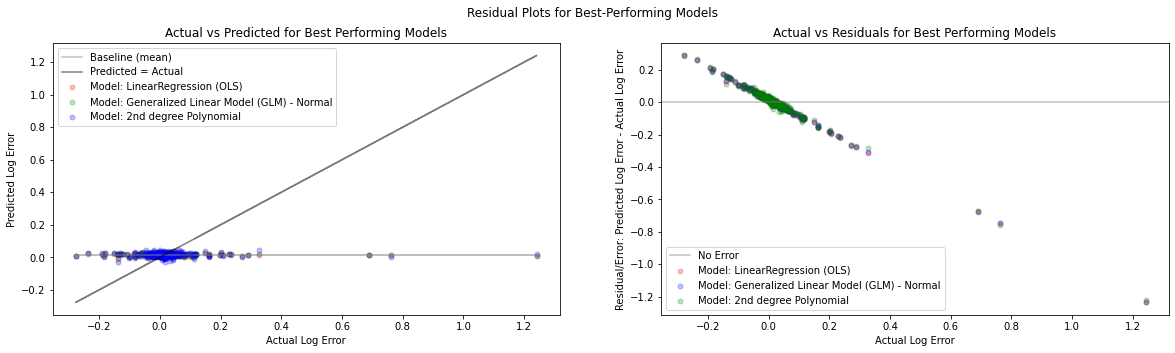

In [188]:
# create residual plots
# ols_y_pred, glm_y_pred_normal, lm2_y_pred

plt.figure(figsize=(20,5)).suptitle('Residual Plots for Best-Performing Models')

plt.subplot(121)

plt.plot(y_validate.log_error.sample(n=250, random_state=527), y_validate.baseline_mean.sample(n=250, random_state=527), alpha=0.5, color="gray", label='Baseline (mean)')
plt.plot(y_validate.log_error.sample(n=250, random_state=527), y_validate.log_error.sample(n=250, random_state=527), alpha=0.5, color="black", label='Predicted = Actual')

plt.scatter(y_validate.log_error.sample(n=250, random_state=527), y_validate.ols_y_pred.sample(n=250, random_state=527), 
            alpha=.25, color="red", s=25, label="Model: LinearRegression (OLS)")
plt.scatter(y_validate.log_error.sample(n=250, random_state=527), y_validate.glm_y_pred_normal.sample(n=250, random_state=527), 
            alpha=.25, color="green", s=25, label="Model: Generalized Linear Model (GLM) - Normal")
plt.scatter(y_validate.log_error.sample(n=250, random_state=527), y_validate.lm2_y_pred.sample(n=250, random_state=527), 
            alpha=.25, color="blue", s=25, label="Model: 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Log Error")
plt.ylabel("Predicted Log Error")
plt.title("Actual vs Predicted for Best Performing Models")

plt.subplot(122)

plt.axhline(label="No Error", color='gray', alpha=0.5)
plt.scatter(y_validate.log_error.sample(n=250, random_state=527), (y_validate.ols_y_pred - y_validate.log_error).sample(n=250, random_state=527), 
            alpha=.25, color="red", s=25, label="Model: LinearRegression (OLS)")
plt.scatter(y_validate.log_error.sample(n=250, random_state=527), (y_validate.glm_y_pred_normal - y_validate.log_error).sample(n=250, random_state=527), 
            alpha=.25, color="blue", s=25, label="Model: Generalized Linear Model (GLM) - Normal")
plt.scatter(y_validate.log_error.sample(n=250, random_state=527), (y_validate.lm2_y_pred - y_validate.log_error).sample(n=250, random_state=527), 
            alpha=.25, color="green", s=25, label="Model: 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Log Error")
plt.ylabel("Residual/Error: Predicted Log Error - Actual Log Error")
plt.title("Actual vs Residuals for Best Performing Models");

### Evaluate Best-Performing Model (GLM Normal) on Test

In [189]:
y_test = pd.DataFrame(y_test)
y_test['baseline_mean'] = y_train.log_error.mean()

# predict on test
y_test['glm_y_pred_normal'] = glm.predict(X_test)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.log_error, y_test.glm_y_pred_normal, squared=False)
r2_test = explained_variance_score(y_test.log_error, y_test.glm_y_pred_normal)

print(f'RMSE for GLM Normal\nOut-of-Sample Performance: {rmse_test:.2f}\nR^2: {r2_test:.3f}')

RMSE for GLM Normal
Out-of-Sample Performance: 0.17
R^2: 0.002


**Compare to Baseline:**

In [190]:
print(f'Model outperformed best baseline:\nRMSE difference: {(mean_squared_error(y_test.log_error, y_test.baseline_mean, squared=False) - rmse_test):.4f}\nR^2 difference: \
{(r2_test - explained_variance_score(y_test.log_error, y_test.baseline_mean)):.3f}')

Model outperformed best baseline:
RMSE difference: 0.0001
R^2 difference: 0.002


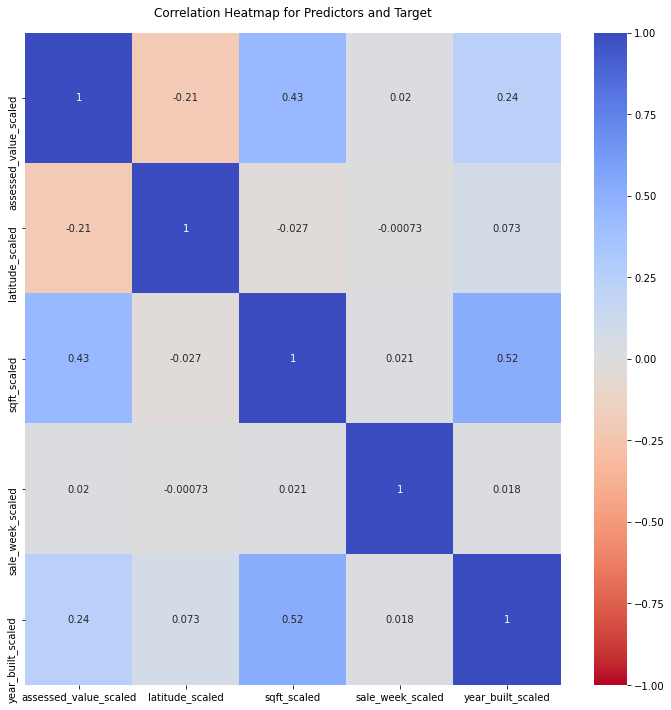

In [191]:
plt.figure(figsize=(12, 12))
heatmap = sns.heatmap(X_train.corr(), annot=True, cmap='coolwarm_r', vmin=-1, vmax=1, center=0)
heatmap.set_title('Correlation Heatmap for Predictors and Target', pad=16);

In [192]:
coef = pd.DataFrame(data={'glm_coef' : glm.coef_}, index = X_train.columns)
coef['abs_glm_coef'] = coef.glm_coef.apply(lambda x: x if x >= 0 else -x)

In [193]:
coef.sort_values(by='abs_glm_coef', ascending=False)

,glm_coef,abs_glm_coef
assessed_value_scaled,-0.034498,0.034498
sqft_scaled,0.022729,0.022729
latitude_scaled,-0.021694,0.021694
year_built_scaled,0.015754,0.015754
sale_week_scaled,-0.007129,0.007129
